# Demonstrate the use of PINT in a script

This notebook is primarily designed to operate as a plain `.py` script.
You should be able to run the `.py` script that occurs in the
`docs/examples/` directory in order to carry out a simple fit of a
timing model to some data. You should also be able to run the notebook
version as it is here (it may be necessary to `make notebooks` to
produce a `.ipynb` version using `jupytext`).

In [1]:
import os

import astropy.units as u

# This will change which output method matplotlib uses and may behave better on some machines
# import matplotlib
# matplotlib.use('TKAgg')

import matplotlib.pyplot as plt
import pint.fitter
import pint.residuals
import pint.toa
from pint.models import get_model_and_toas
import pint.logging
import os

# setup logging
pint.logging.setup(level="INFO")

1

In [2]:
import pint.config

parfile = pint.config.examplefile("NGC6440E.par")
timfile = pint.config.examplefile("NGC6440E.tim")
assert os.path.exists(parfile)
assert os.path.exists(timfile)

In [3]:
# Read the timing model and the TOAs
m, t = get_model_and_toas(parfile, timfile)

If we wanted to do things separately we could do
```python
# Define the timing model
m = get_model(parfile)
# Read in the TOAs, using the solar system ephemeris and other things from the model
t = pint.toa.get_TOAs(timfile, model=m)
```

If we wanted to select some subset of the TOAs, there are tools to do that. Most easily
you make a new TOAs object containing the subset you care about (we will make but not use
them):

Use every other TOA

In [4]:
t_every_other = t[::2]

Use only TOAs with errors < 30 us

In [5]:
t_small_errors = t[t.get_errors() < 30 * u.us]

Use only TOAs from the GBT (although this is all of them for this example)

In [6]:
t_gbt = t[t.get_obss() == "gbt"]

In [7]:
# Print a summary of the TOAs that we have
print(t.get_summary())

Number of TOAs:  62
Number of commands:  0
Number of observatories: 1 ['gbt']
MJD span:  53478.286 to 54187.587
Date span: 2005-04-18 06:51:39.290648106 to 2007-03-28 14:05:44.808308037
gbt TOAs (62):
  Min freq:      1549.609 MHz
  Max freq:      2212.109 MHz
  Min error:     13.2 us
  Max error:     118 us
  Median error:  22.1 us



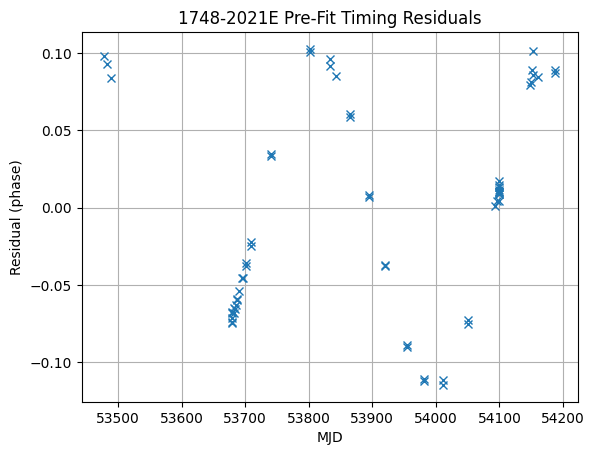

In [8]:
# These are pre-fit residuals
rs = pint.residuals.Residuals(t, m).phase_resids
xt = t.get_mjds()
plt.plot(xt, rs, "x")
plt.title(f"{m.PSR.value} Pre-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (phase)")
plt.grid()
plt.show()

In [9]:
# Now do the fit
print("Fitting.")
f = pint.fitter.DownhillWLSFitter(t, m)
f.fit_toas()
# f = pint.fitter.DownhillGLSFitter(t, m)
# f.fit_toas(full_cov=True)

Fitting.


In [10]:
# Print some basic params
print("Best fit has reduced chi^2 of", f.resids.reduced_chi2)
print("RMS in phase is", f.resids.phase_resids.std())
print("RMS in time is", f.resids.time_resids.std().to(u.us))

Best fit has reduced chi^2 of 1.0638341436607690591
RMS in phase is 0.0020495747259610133
RMS in time is 33.334290336833924 us


In [11]:
# Show the parameter correlation matrix
corm = f.get_parameter_correlation_matrix(pretty_print=True)


Parameter correlation matrix:
         RAJ   DECJ    F0     F1     DM   
  RAJ    1.000
 DECJ   -0.072  1.000
  F0    -0.087  0.247  1.000
  F1     0.294 -0.344 -0.798  1.000
  DM    -0.005  0.065  0.007  0.058  1.000




In [12]:
print(f.get_summary())

Fitted model using downhill_wls method with 5 free parameters to 62 TOAs
Prefit residuals Wrms = 1090.5801805746107 us, Postfit residuals Wrms = 21.182108487867104 us
Chisq = 59.575 for 56 d.o.f. for reduced Chisq of 1.064

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           1748-2021E 1748-2021E                   None
EPHEM                              DE421 DE421                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                                                         53478.3 d 
FINISH                                                        54187.6 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
DILATEFREQ                  

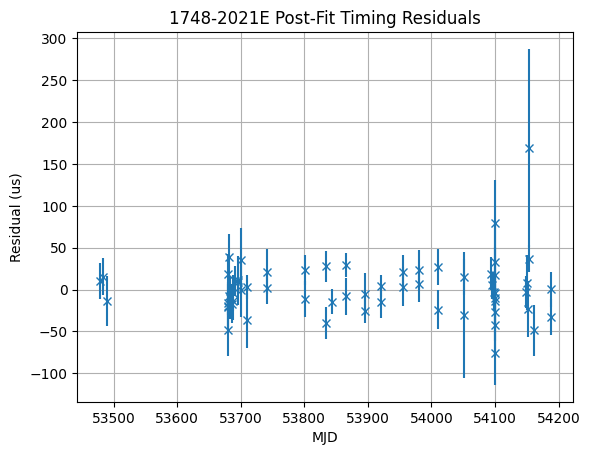

In [13]:
plt.errorbar(
    xt.value,
    f.resids.time_resids.to_value(u.us),
    t.get_errors().to_value(u.us),
    fmt="x",
)
plt.title(f"{m.PSR.value} Post-Fit Timing Residuals")
plt.xlabel("MJD")
plt.ylabel("Residual (us)")
plt.grid()
plt.show()

In [14]:
f.model.write_parfile("/tmp/output.par", "wt")
print(f.model.as_parfile())

# Created: 2024-04-26T18:13:11.751550
# PINT_version: 1.0
# User: docs
# Host: build-24199868-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                            1748-2021E
EPHEM                               DE421
CLK                          TT(BIPM2019)
UNITS                                 TDB
START              53478.2858714195382639
FINISH             54187.5873241702319097
TIMEEPH                              FB90
T2CMETHOD                        IAU2000B
DILATEFREQ                              N
DMDATA                                  N
NTOA                                   62
CHI2                    59.57471204500307
CHI2R                   1.063834143660769
TRES                21.182108487867104272
RAJ                     17:48:52.80034690 1 0.00013524663578313309
DECJ                   -20:21:29.38334050 1 0.03285268549434944285
PMRA                           